# 04: 重みの初期化 (Weight Initialization)

このノートブックでは、ニューラルネットワークの学習の「出発点」を決定する、極めて重要なステップである「重みの初期化」について学びます。
不適切な初期化は、学習が全く進まない「勾配消失」や、学習が不安定になる「勾配爆発」といった深刻な問題を引き起こします。なぜそのような問題が起きるのかを理論的に理解し、それを解決するための代表的な初期化手法であるXavier初期化とHe初期化を実装を通して学びます。

**参考論文:**
*   (Xavier/Glorot) Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks.
*   (He) He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving deep into rectifiers: surpassing human-level performance on ImageNet classification.

**このノートブックで学ぶこと:**
1.  なぜ重みの初期化が重要なのか。
2.  不適切な初期化（ゼロ初期化、大きすぎる/小さすぎる値）が引き起こす問題。
3.  各層のアクティベーション（出力値）の分布を一定に保つという考え方。
4.  Xavier (Glorot) 初期化の理論と実装。
5.  He初期化の理論と実装、そしてReLU系活性化関数との関係。
6.  どの初期化手法をいつ使うべきかのガイドライン。

**前提知識:**
*   ニューラルネットワークの順伝播の計算フロー。
*   活性化関数（特にTanh, ReLU）の特性。
*   統計学の基礎知識（分散、標準偏差）。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [13]:
import numpy as np
import matplotlib.pyplot as plt

## 2. なぜ重みの初期化が重要なのか？

ニューラルネットワークの学習は、ランダムに設定された重みの初期値からスタートし、勾配降下法によって徐々に最適な値へと近づけていくプロセスです。この「出発点」である初期値の選び方は、学習全体の成否を大きく左右します。

良い初期化の目標は、**学習プロセスを通じて、各層の出力（アクティベーション）の分散を適切な範囲に保ち、勾配が消失したり発散したりするのを防ぐこと**です。

もし、層を通過するたびに出力の分散が小さくなっていくと、最終層に届く頃には信号がほとんど0になり、逆伝播で計算される勾配も0に近づきます（**勾配消失**）。
逆に、層を通過するたびに出力の分散が大きくなっていくと、信号は極端な値に発散し、勾配もまた発散します（**勾配爆発**）。

適切な初期化は、信号がネットワークをスムーズに流れ、勾配が効率的に逆伝播するための「道筋」を整える役割を担います。

## 3. 不適切な初期化の実験

まずは、不適切な初期化がどのような問題を引き起こすかを、簡単な実験を通して可視化してみましょう。
ここでは、5層のMLPに、標準正規分布からサンプリングしたデータを入力し、各層のアクティベーションがどのように変化するかを観察します。

### 3.1 ゼロ初期化

最も単純な考えは、全ての重みを0で初期化することです。しかし、これは致命的な欠陥を持ちます。
もし全ての重みが0であれば、全てのニューロンは同じ計算を行い、同じ値を出力します。逆伝播においても、全てのニューロンが同じ勾配を受け取り、同じように更新されます。これでは、ニューロンが複数ある意味がなく、モデルは対称性を崩すことができずに全く学習が進みません。

### 3.2 小さすぎる/大きすぎる初期化

では、ランダムな値で初期化すれば良いのでしょうか。そのスケール（分散の大きさ）が重要になります。
ここでは、標準正規分布に従う乱数を生成し、それに小さな定数（0.01）や大きな定数（1.0）を乗算して初期化してみます。活性化関数には`tanh`を使用します。

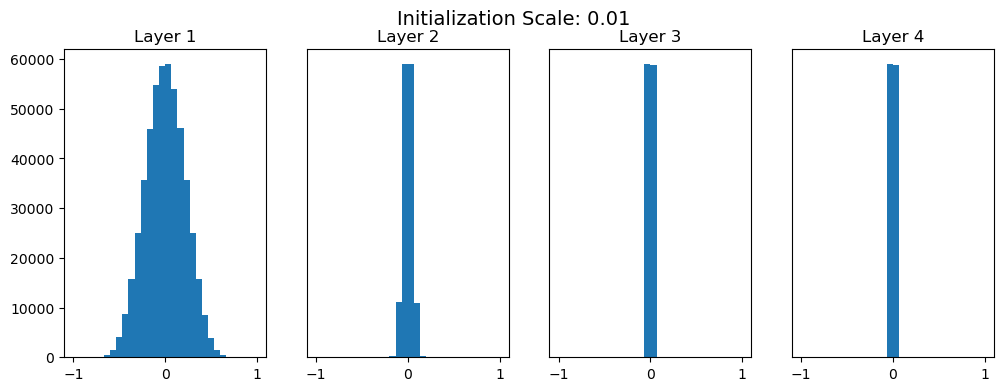

Standard Deviations of Activations:
  Layer 1: 0.2136
  Layer 2: 0.0475
  Layer 3: 0.0106
  Layer 4: 0.0024
----------------------------------------


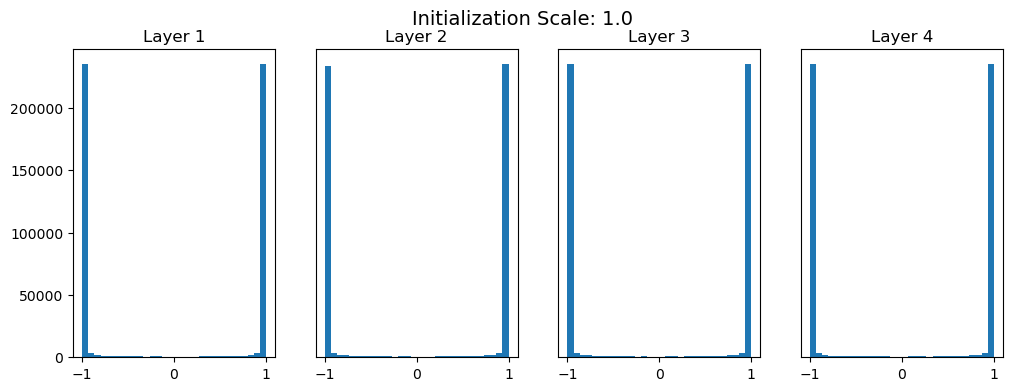

Standard Deviations of Activations:
  Layer 1: 0.9820
  Layer 2: 0.9817
  Layer 3: 0.9817
  Layer 4: 0.9817
----------------------------------------


In [14]:
def tanh(x):
    return np.tanh(x)

def simulate_activations(init_scale):
    """
    指定されたスケールで重みを初期化し、各層のアクティベーションの分布を計算・プロットする関数
    """
    input_data = np.random.randn(1000, 500)  # 1000個のデータ、500次元
    hidden_layer_size = [500, 500, 500, 500]
    activations = {}
    x = input_data

    # 5層のネットワークを順伝播
    for i in range(len(hidden_layer_size)):
        W = np.random.randn(x.shape[1], hidden_layer_size[i]) * init_scale
        a = np.dot(x, W)
        x = tanh(a)
        activations[i] = x
    
    # 各層のアクティベーションのヒストグラムを描画
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Initialization Scale: {init_scale}', fontsize=14)
    for i, a in activations.items():
        plt.subplot(1, len(activations), i + 1)
        plt.title(f"Layer {i + 1}")
        plt.hist(a.flatten(), 30, range=(-1, 1))
        if i != 0: plt.yticks([])
    plt.show()

    # 各層のアクティベーションの標準偏差を出力
    print("Standard Deviations of Activations:")
    for i, a in activations.items():
        print(f"  Layer {i+1}: {np.std(a):.4f}")
    print("-" * 40)

# 小さすぎる初期化
simulate_activations(0.01)

# 大きすぎる初期化
simulate_activations(1.0)

**実験結果の考察**

*   **スケール 0.01 (小さすぎる初期化)**:
    各層のアクティベーションの分布は、層が進むごとに0の周りに集中し、その標準偏差も急速に0に近づいています。これは、入力信号が層を通過するたびに縮小し、最終的にはほとんど情報が失われてしまうことを示しています。これが**勾配消失**の原因となります。

*   **スケール 1.0 (大きすぎる初期化)**:
    逆に、スケールが大きすぎると、多くのアクティベーションが-1か1のどちらかに張り付いてしまっています。Tanh関数のグラフを思い出してください。これらの値の領域では、関数の傾き（勾配）はほぼ0です。そのため、逆伝播の際に勾配が伝わらず、これもまた**勾配消失**を引き起こします。アクティベーションの値自体は発散気味ですが、勾配は消失するという、一見矛盾した状況が生まれます。

この実験から、初期化のスケールを「ちょうど良い」値に設定することがいかに重要かがわかります。

## 4. Xavier (Glorot) 初期化

Xavier GlorotとYoshua Bengioは、この問題を解決するために、**各層の入力と出力の分散を等しく保つ**というアイデアを提案しました。これにより、信号が層を通過してもその大きさが変わらず、勾配もスムーズに伝播することが期待できます。

**理論:**
ある層の入力$x$と重み$W$について、以下の仮定を置きます。
*   $x$と$W$は互いに独立で、平均は0。
*   $x$の各要素の分散は $\text{Var}(x)$。
*   $W$の各要素の分散は $\text{Var}(W)$。

この層の出力 $y = \sum_{i=1}^{n_{in}} W_i x_i$ の分散は、
$$
\text{Var}(y) = \text{Var}(\sum_{i=1}^{n_{in}} W_i x_i) = \sum_{i=1}^{n_{in}} \text{Var}(W_i x_i)
$$
$x_i$と$W_i$が独立で平均0なので、$\text{Var}(W_i x_i) = \text{Var}(W_i)\text{Var}(x_i)$ となります。
$$
\text{Var}(y) = n_{in} \text{Var}(W) \text{Var}(x)
$$
ここで、$n_{in}$ は入力ニューロンの数です。

**順伝播**において、出力の分散 $\text{Var}(y)$ を入力の分散 $\text{Var}(x)$ と等しく保つためには、
$$
n_{in} \text{Var}(W) = 1 \quad \implies \quad \text{Var}(W) = \frac{1}{n_{in}}
$$
となる必要があります。

同様に、**逆伝播**において勾配の分散を保つためには、出力ニューロンの数を $n_{out}$ として、
$$
n_{out} \text{Var}(W) = 1 \quad \implies \quad \text{Var}(W) = \frac{1}{n_{out}}
$$
が望ましいです。

Xavier初期化は、この両方の条件を考慮し、その中間をとります。

**Xavier初期化の分散:**
$$
\text{Var}(W) = \frac{2}{n_{in} + n_{out}}
$$
これは、活性化関数が線形であると仮定した場合の導出です。`tanh`のような原点付近で線形とみなせる関数でうまく機能します。

**実装:**
この分散を持つ正規分布、または一様分布からサンプリングします。
*   **正規分布の場合**: 平均0, 標準偏差 $\sigma = \sqrt{\frac{2}{n_{in} + n_{out}}}$
*   **一様分布の場合**: $[-r, r]$ の範囲で、$\text{Var}(W) = \frac{r^2}{3}$ より $r = \sqrt{\frac{6}{n_{in} + n_{out}}}$

Using Xavier Initialization


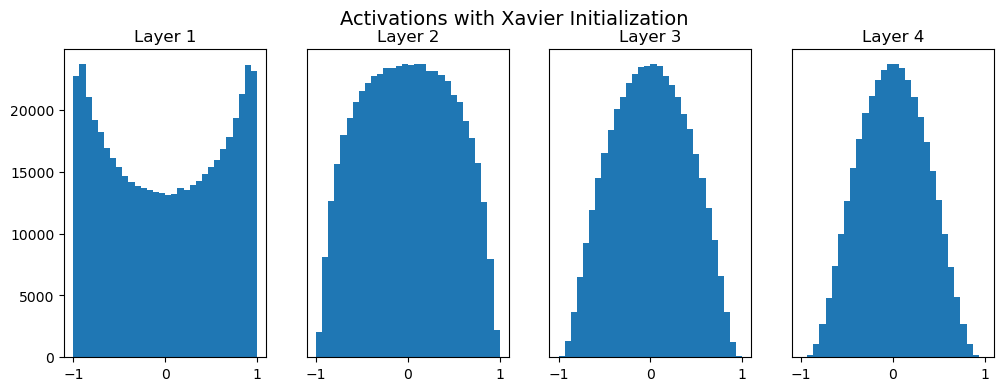

Standard Deviations of Activations:
  Layer 1: 0.6277
  Layer 2: 0.4866
  Layer 3: 0.4072
  Layer 4: 0.3567
----------------------------------------


In [15]:
def xavier_initialization_experiment():
    input_data = np.random.randn(1000, 500)
    hidden_layer_size = [500, 500, 500, 500]
    activations = {}
    x = input_data

    print("Using Xavier Initialization")
    for i in range(len(hidden_layer_size)):
        n_in = x.shape[1]
        n_out = hidden_layer_size[i]
        # Xavier初期化 (正規分布)
        # stddev = np.sqrt(1 / n_in)  # 論文の別バリアント
        stddev = np.sqrt(2 / (n_in + n_out))
        W = np.random.randn(n_in, n_out) * stddev
        a = np.dot(x, W)
        x = tanh(a)
        activations[i] = x
        
    # 各層のアクティベーションのヒストグラムを描画
    plt.figure(figsize=(12, 4))
    plt.suptitle('Activations with Xavier Initialization', fontsize=14)
    for i, a in activations.items():
        plt.subplot(1, len(activations), i + 1)
        plt.title(f"Layer {i + 1}")
        plt.hist(a.flatten(), 30, range=(-1, 1))
        if i != 0: plt.yticks([])
    plt.show()

    # 各層のアクティベーションの標準偏差を出力
    print("Standard Deviations of Activations:")
    for i, a in activations.items():
        print(f"  Layer {i+1}: {np.std(a):.4f}")
    print("-" * 40)

xavier_initialization_experiment()

**Xavier初期化の結果**

先ほどの不適切な初期化の例とは対照的に、各層のアクティベーションの分布が広がりを保ち、標準偏差も安定していることがわかります。これにより、信号と勾配がネットワークをスムーズに流れることができ、効率的な学習が可能になります。

## 5. He 初期化

Xavier初期化は`tanh`や`sigmoid`ではうまく機能しましたが、現代の標準である`ReLU`を用いると、再び問題が発生します。

`ReLU`は入力の負の半分を0にしてしまうため、出力の分散が約半分になってしまいます。
$$
\text{Var}(\text{ReLU}(y)) \approx \frac{1}{2}\text{Var}(y)
$$
これを考慮に入れると、`ReLU`を使った場合の出力の分散は、
$$
\text{Var}(\text{ReLU}(y)) \approx \frac{1}{2} n_{in} \text{Var}(W) \text{Var}(x)
$$
となります。
この分散を入力の分散 $\text{Var}(x)$ と等しく保つためには、
$$
\frac{1}{2} n_{in} \text{Var}(W) = 1 \quad \implies \quad \text{Var}(W) = \frac{2}{n_{in}}
$$
とする必要があります。これが**He初期化**です。

**He初期化の分散:**
$$
\text{Var}(W) = \frac{2}{n_{in}}
$$

**実装:**
*   **正規分布の場合**: 平均0, 標準偏差 $\sigma = \sqrt{\frac{2}{n_{in}}}$
*   **一様分布の場合**: $[-r, r]$ の範囲で、$r = \sqrt{\frac{6}{n_{in}}}$

Using He Initialization with ReLU


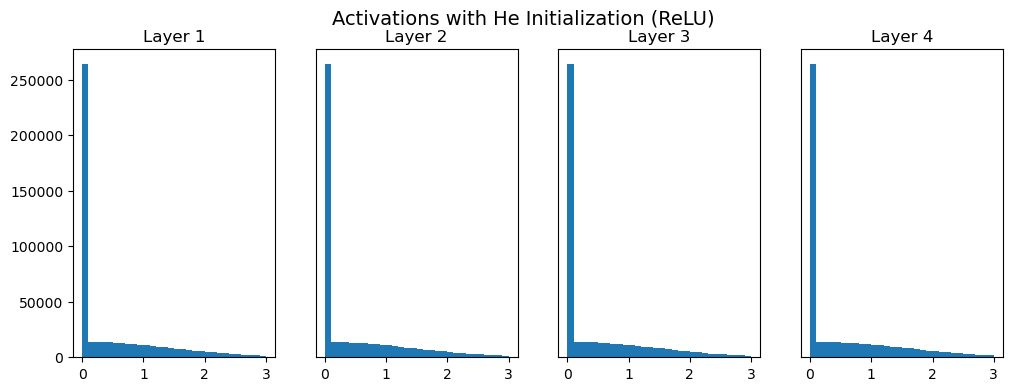

Standard Deviations of Activations:
  Layer 1: 0.8249
  Layer 2: 0.8154
  Layer 3: 0.8109
  Layer 4: 0.8354
----------------------------------------
Using Xavier Initialization with ReLU (Incorrect combination)


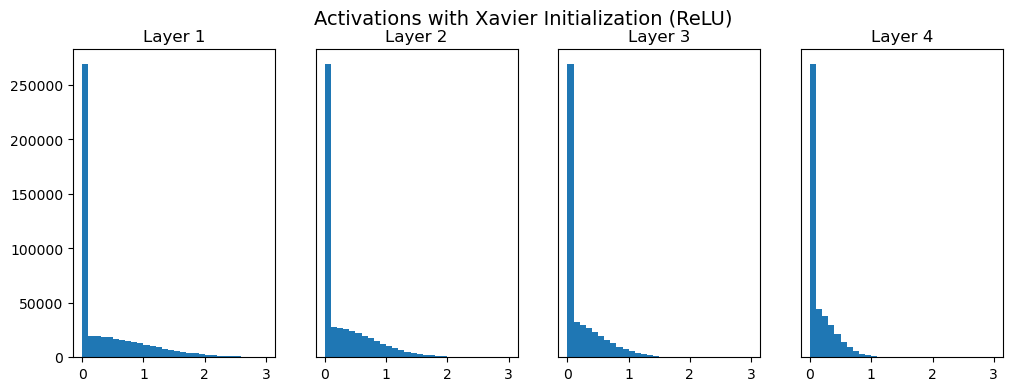

Standard Deviations of Activations (Xavier with ReLU):
  Layer 1: 0.5856
  Layer 2: 0.4343
  Layer 3: 0.3208
  Layer 4: 0.2145


In [16]:
def relu(x):
    return np.maximum(0, x)

def he_initialization_experiment():
    input_data = np.random.randn(1000, 500)
    hidden_layer_size = [500, 500, 500, 500]
    activations = {}
    x = input_data

    print("Using He Initialization with ReLU")
    for i in range(len(hidden_layer_size)):
        n_in = x.shape[1]
        # He初期化 (正規分布)
        stddev = np.sqrt(2 / n_in)
        W = np.random.randn(n_in, hidden_layer_size[i]) * stddev
        a = np.dot(x, W)
        x = relu(a)  # 活性化関数にReLUを使用
        activations[i] = x
        
    # 各層のアクティベーションのヒストグラムを描画
    plt.figure(figsize=(12, 4))
    plt.suptitle('Activations with He Initialization (ReLU)', fontsize=14)
    for i, a in activations.items():
        plt.subplot(1, len(activations), i + 1)
        plt.title(f"Layer {i + 1}")
        plt.hist(a.flatten(), 30, range=(0, 3)) # ReLUなので範囲を調整
        if i != 0: plt.yticks([])
    plt.show()

    # 各層のアクティベーションの標準偏差を出力
    print("Standard Deviations of Activations:")
    for i, a in activations.items():
        print(f"  Layer {i+1}: {np.std(a):.4f}")
    print("-" * 40)
    
    # 比較のため、Xavier初期化をReLUで使った場合も試す
    print("Using Xavier Initialization with ReLU (Incorrect combination)")
    x = input_data
    activations_xavier = {}
    for i in range(len(hidden_layer_size)):
        n_in = x.shape[1]
        stddev = np.sqrt(1 / n_in) # Xavierのバリアント
        W = np.random.randn(n_in, hidden_layer_size[i]) * stddev
        a = np.dot(x, W)
        x = relu(a)
        activations_xavier[i] = x

    # 各層のアクティベーションのヒストグラムを描画
    plt.figure(figsize=(12, 4))
    plt.suptitle('Activations with Xavier Initialization (ReLU)', fontsize=14)
    for i, a in activations_xavier.items():
        plt.subplot(1, len(activations_xavier), i + 1)
        plt.title(f"Layer {i + 1}")
        plt.hist(a.flatten(), 30, range=(0, 3)) # ReLUなので範囲を調整
        if i != 0: plt.yticks([])
    plt.show()
    
    print("Standard Deviations of Activations (Xavier with ReLU):")
    for i, a in activations_xavier.items():
        print(f"  Layer {i+1}: {np.std(a):.4f}")

he_initialization_experiment()

**He初期化の結果**

He初期化をReLUと組み合わせた場合、各層のアクティベーションの標準偏差が0.7〜0.8程度で安定していることがわかります。
一方、比較のためにXavier初期化をReLUと組み合わせると、理論通り、層が進むにつれて標準偏差が減少し、勾配消失のリスクが高まることが確認できます。

このことから、活性化関数と重みの初期化手法には密接な関係があり、適切な組み合わせを選ぶことが重要であると結論付けられます。

## 6. まとめと実践的なガイドライン

| 活性化関数 | 推奨される初期化手法 |
| :--- | :--- |
| Sigmoid, Tanh | **Xavier (Glorot) 初期化** |
| ReLU, Leaky ReLU, ELU | **He 初期化** |

**実践的なガイドライン:**
*   現代のディープラーニングでは、中間層の活性化関数としてReLUファミリーが広く使われています。したがって、**He初期化がほとんどの場合でデフォルトの選択肢**となります。
*   PyTorchやTensorFlowのようなフレームワークでは、`nn.Linear`や`nn.Conv2d`層のデフォルトの初期化は、すでにこれらのベストプラクティス（通常はHe初期化）に従って実装されています。そのため、多くの場合、ユーザーが明示的に初期化をコーディングする必要はありません。
*   しかし、カスタムレイヤーを実装する場合や、学習がうまくいかない原因を探る際には、この初期化の理論を理解していることが不可欠です。

重みの初期化は、学習の成功を左右する最初の、そして非常に重要なステップです。適切な手法を選択することで、深いネットワークであっても安定した学習を実現する土台を築くことができます。